In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg

# Look at stylegan-generated images

In [2]:
DIR_ORIG = '../data/annotation-dataset-stylegan2/images'
DIRS_STYLEGAN = '../data_processed/stylegan2'


In [3]:
regs = [0, 0.1, 1, 10000]
IM_NUMS = [0, 1, 10]

In [ ]:
plt.figure(dpi=300)
R, C = len(IM_NUMS), 1 + len(regs)
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_STYLEGAN, folder, f'{IM_NUM}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])

# Look at CELEB-A

In [5]:
DIR_ORIG_CELEBA = '../data/CelebA/Img/img_align_celeba'
DIR_SQUARE_CELEBA = '../data/CelebA/Img/img_square_celeba'

**need to first preprocess celeba to be square before running the pipeline**

In [ ]:
for fname in tqdm(sorted(os.listdir(DIR_ORIG_CELEBA))):
    if '.jpg' in fname:
        im = mpimg.imread(oj(DIR_ORIG_CELEBA, fname))
        if not im.shape[0] == im.shape[1]:
            im = im[20:-20]
        plt.imsave(oj(DIR_SQUARE_CELEBA, fname), im)

# look at celeba-hq

In [46]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(6, 10)

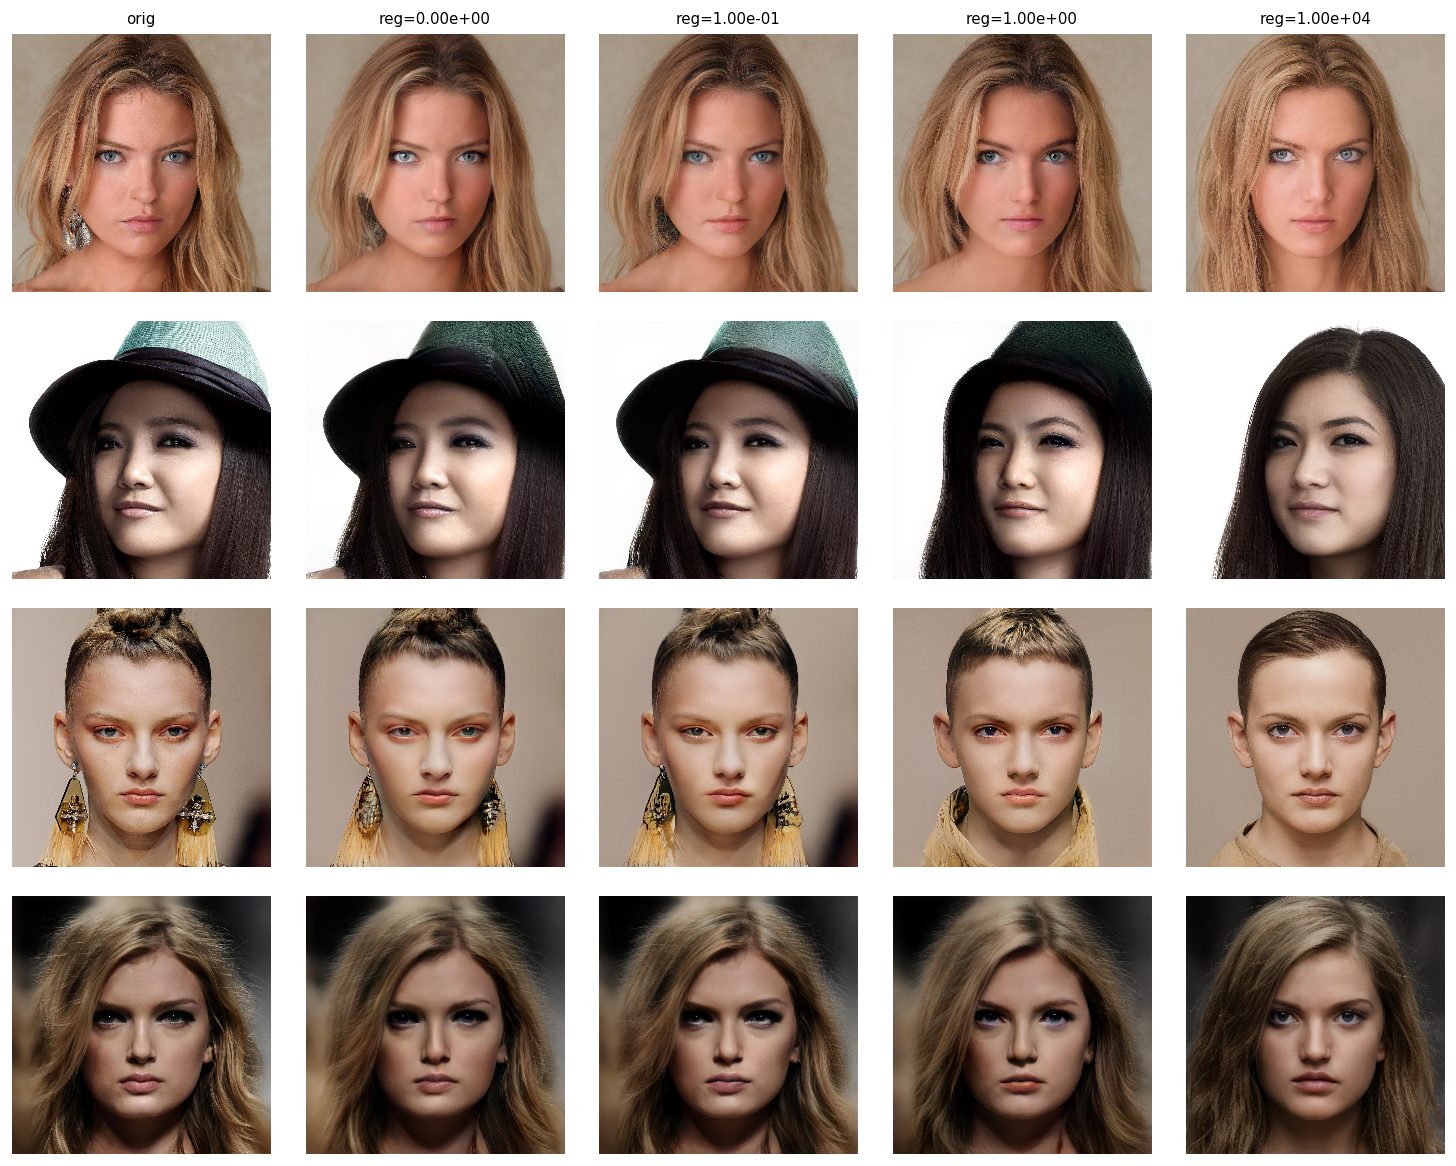

In [26]:
R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_GEN, folder, f'{IM_NUM:05}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
    latents = np.array(latents)
plt.tight_layout()

**load celeba labels**

In [10]:
sys.path.append('../models/stylegan2encoder')
import pretrained_networks
import projector

In [ ]:
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
_, _, Gs = pretrained_networks.load_networks(network_pkl)
proj = projector.Projector()
proj.set_network(Gs)

In [47]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'
regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(6, 10)

In [49]:
# want df where each row is an image, columns are {stat}_{reg_param}
r = {

}
latent_index = 0
im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
im_orig = np.expand_dims(np.transpose(im_orig, (2, 0, 1)), 0)
vgg_loss = proj.get_vgg_loss(im_orig,
                  latents=latents[latent_index: latent_index + 1])
mean_abs_corr = np.mean(np.abs(np.corrcoef(latents[latent_index])))

(1, 3, 1024, 1024)
target shahpe (1, 3, 256, 256)
targ im shpae (1, 3, 256, 256)
(1, 3, 1024, 1024)
sh [1, 3, 1024, 1024]
0.16167260620206605


In [48]:
im_orig.shape

(1, 3, 1024, 1024)

In [77]:
celeba_labs_fname = '../data/celeba-hq/Anno/list_attr_celeba.txt'
labs_full = pd.read_csv(celeba_labs_fname, delim_whitespace=True, skiprows=1)
labs = pd.DataFrame()
# print(labs.keys())
# print(labs_full.keys())

# large is more male
labs['Gender'] = labs_full['Male']

# larger is longer
labs['Hair-length'] = -1 * labs_full['Bald'] # Bangs, Receding_Hairline

# larger is more
labs['Facial-hair'] = labs_full['Mustache'] # Goatee, Mustache, No_Beard, 5_o_Clock_Shadow

# higher is more
labs['Makeup'] = labs_full['Heavy_Makeup'] # Wearing_Lipstick

# higher is darker
labs['Skin-color'] = labs_full['Pale_Skin'] * -1

# older is more positive
labs['Age'] = labs_full['Young'] * -1